In [41]:
import pandas as pd
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier, XGBRegressor

In [30]:
df = pd.read_csv("./outputs/train_processed.csv")
df.sample(20)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
682,1,0,0,1,12.30,13.635,28,22.0028,30,84,114,2,12,11
7587,2,0,1,1,25.42,31.060,38,27.9993,91,554,645,6,4,19
2947,3,0,1,1,28.70,32.575,51,15.0013,92,251,343,7,15,20
6335,1,0,1,1,17.22,21.210,77,15.0013,1,28,29,3,8,5
6907,2,0,0,1,14.76,18.180,66,7.0015,2,5,7,4,14,5
3589,3,0,0,1,30.34,34.850,70,19.9995,104,125,229,9,4,20
2882,3,0,1,1,30.34,34.090,58,12.9980,0,4,4,7,13,3
4235,4,0,1,3,22.14,25.760,94,6.0032,13,41,54,10,12,23
5048,4,0,1,2,12.30,15.150,70,11.0014,11,115,126,12,9,10
8698,3,0,1,1,31.98,34.850,40,11.0014,79,175,254,8,13,13


In [31]:
X = df.copy(deep=True).drop(columns=["count"])
y = pd.Series(df.copy(deep=True)["count"])

X.shape, y.shape

((10659, 13), (10659,))

In [32]:
rfr = RandomForestRegressor()

rfr.fit(X, y)
feature_importances = pd.Series(rfr.feature_importances_, index=X.columns)

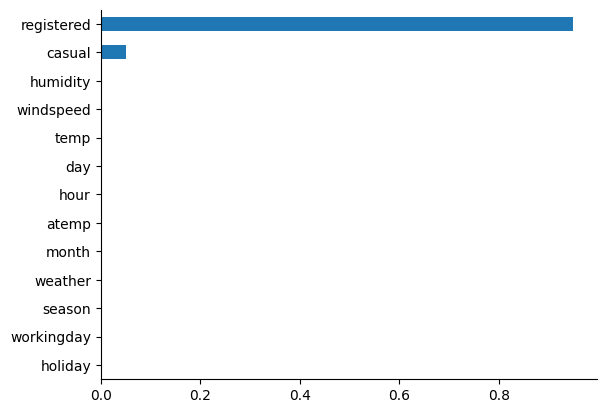

In [33]:
feature_importances.sort_values().plot(kind="barh")
sns.despine()

In [ ]:
xgr = XGBRegressor()
xgr.fit(X, y)

feature_importances = pd.Series(xgr.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind="barh")
sns.despine()

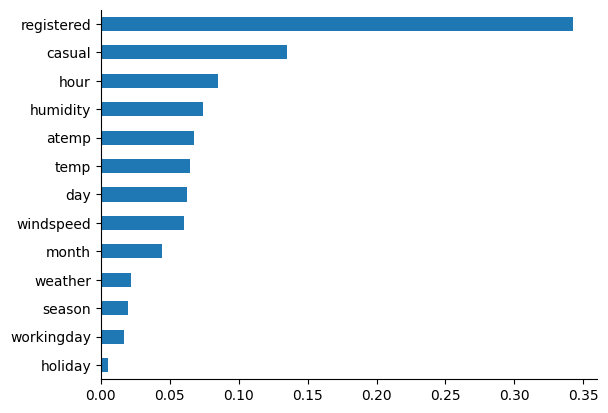

In [34]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1)
rfc.fit(X, y)

classifier_feature_importance = pd.Series(rfc.feature_importances_, index=X.columns)
classifier_feature_importance.sort_values().plot(kind="barh")
sns.despine()


In [46]:
classifiers = {
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200]
        },
    },
    "svc": {
        "model": SVC(),
        "params": {
            "svc__C": [1, 10, 100],
            "svc__gamma": [0.1, 0.01, 0.001],
            "svc__kernel": ["rbf", "linear"],
        },
    },
    "logistic_regression": {
        "model": LogisticRegression(),
        "params": {"C": [1, 10, 100], "solver": ["liblinear"]},
    },
    # "xgboost": {
    #     "model": XGBClassifier(),
    #     "params": {
    #         "n_estimators": [50, 100, 200],
    #         "max_depth": [5, 10, 15],
    #         "learning_rate": [0.1, 0.01, 0.001],
    #     },
    # },
}

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [48]:
def run_classifiers(
    classifiers: dict[str, dict], X_train: pd.DataFrame, y_train: pd.Series
) -> Pipeline:

    for classifier_key, classifier_content in classifiers.items():
        if classifier_key == "svc":
            pipeline = make_pipeline(StandardScaler(), classifier_content["model"])
            clf = GridSearchCV(
                estimator=pipeline,
                param_grid=classifier_content["params"],
                cv=2,
                verbose=2,
            )
            clf.fit(X_train, y_train)
        elif classifier_key == "xgboost":
            clf = GridSearchCV(
                estimator=classifier_content["model"],
                param_grid=classifier_content["params"],
                cv=2,
                verbose=2,
            )
            le = LabelEncoder()
            le_y_train = le.fit_transform(y_train)
            clf.fit(X_train, le_y_train)
        else:
            clf = GridSearchCV(
                estimator=classifier_content["model"],
                param_grid=classifier_content["params"],
                cv=2,
                verbose=2,
            )
            clf.fit(X_train, y_train)

    return clf.best_estimator_

In [49]:
clf = run_classifiers(classifiers, X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Users/jcbraz/University/BBS/bike-sharing-demand/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


[CV] END ....................................n_estimators=50; total time=   2.4s
[CV] END ....................................n_estimators=50; total time=   2.2s
[CV] END ...................................n_estimators=100; total time=   4.8s
[CV] END ...................................n_estimators=100; total time=   4.4s
[CV] END ...................................n_estimators=200; total time=   9.2s
[CV] END ...................................n_estimators=200; total time=   9.1s
Fitting 2 folds for each of 18 candidates, totalling 36 fits


/Users/jcbraz/University/BBS/bike-sharing-demand/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   8.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   8.2s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   8.4s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   8.4s
[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=   8.0s
[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=   7.9s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   8.5s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   8.4s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   7.9s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   7.7s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   8.5s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   8.3s
[CV] END .........svc__C=10,

/Users/jcbraz/University/BBS/bike-sharing-demand/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


[CV] END ..............................C=1, solver=liblinear; total time=   8.5s
[CV] END ..............................C=1, solver=liblinear; total time=   8.6s
[CV] END .............................C=10, solver=liblinear; total time=  12.8s
[CV] END .............................C=10, solver=liblinear; total time=  13.2s


/Users/jcbraz/University/BBS/bike-sharing-demand/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=100, solver=liblinear; total time=  16.8s


/Users/jcbraz/University/BBS/bike-sharing-demand/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=100, solver=liblinear; total time=  17.4s


In [50]:
clf

LogisticRegression(C=10, solver='liblinear')

In [51]:
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
score # AHAHHAHHAHAH

0.04263786242183058

In [ ]:
if not os.path.exists("./models"):
    os.makedirs("./models")

joblib.dump(clf.best_estimator_, "./models/classifier.pkl")